### Téléchargement et aperçu du dataset MedMentions

MedMentions est un corpus contenant des entités biomédicales extraites de PubMed.  
Les annotations incluent des entités comme des maladies, des traitements, et d'autres concepts biomédicaux.

In [32]:
import gzip
import pandas as pd

# Chemin vers le fichier compressé PubTator
file_path = 'corpus_pubtator.txt.gz'

# Ouverture et lecture du fichier compressé
with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    data = f.readlines()

# Affichage des premières lignes pour inspecter le format
for line in data[:1000]:
    print(line.strip())


25763772|t|DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis
25763772|a|Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been incl

Le dataset MedMentions est fourni au format PubTator compressé (corpus_pubtator.txt.gz). Le format PubTator est souvent utilisé dans les corpus biomédicaux et contient à la fois les textes et les annotations dans un fichier texte structuré.

#### Structure du fichier PubTator

Le fichier corpus_pubtator.txt.gz contient des documents annotés selon ce format :

    Chaque document commence par un PMID (identifiant unique du document).
    Ensuite, il y a des lignes avec le titre et le résumé du document.
    Les annotations suivent sous forme de lignes décrivant les entités biomédicales (mentionnées par leur position dans le texte, leur type et leur identifiant UMLS).

Le UMLS (Unified Medical Language System) est un système développé par la National Library of Medicine (NLM) des États-Unis pour faciliter l'intégration et l'interopérabilité des terminologies biomédicales et des systèmes d'information en santé.  
  
Les concepts médicaux sont identifiés par un Concept Unique Identifier (CUI).  
Par exemple:
CUI : C0011849 correspond au concept "Diabetes Mellitus".  
CUI : C0004238 correspond au concept "Cancer". Chaque concept est lié à plusieurs termes et codes issus de différentes sources terminologiques.  
  
De même, les types sémantiques de l'UMLS sont documentés et classés dans le Semantic Network de l'UMLS.  
Exemple des types sémantiques :  
T047 : Disease or Syndrome (Maladie ou Syndrome)  
T116 : Amino Acid, Peptide, or Protein  
T121 : Pharmacologic Substance  
T195 : Antibiotic  

In [33]:
pmid_to_text = {}
pmid_to_annotations = {}

for line in data:
    line = line.strip()
    
    if "|t|" in line:  # Titre de l'article
        pmid, title = line.split('|t|')
        pmid_to_text[pmid] = {'title': title, 'abstract': ''}
    
    elif "|a|" in line:  # Résumé de l'article
        pmid, abstract = line.split('|a|')
        pmid_to_text[pmid]['abstract'] = abstract
    
    elif len(line.split('\t')) == 6:  # Annotations
        pmid, start, end, mention, sem_type, umls_id = line.split('\t')
        if pmid not in pmid_to_annotations:
            pmid_to_annotations[pmid] = []
        pmid_to_annotations[pmid].append({
            'start': start, 'end': end, 'mention': mention,
            'sem_type': sem_type, 'umls_id': umls_id
        })

# Exemple d'accès aux données extraites
print(pmid_to_text['26316050'])  # Affiche le titre et résumé pour un PMID donné
print(pmid_to_annotations['26406200'])  # Affiche les annotations pour ce même document


{'title': 'Prevascularized silicon membranes for the enhancement of transport to implanted medical devices', 'abstract': 'Recent advances in drug delivery and sensing devices for in situ applications are limited by the diffusion -limiting foreign body response of fibrous encapsulation. In this study, we fabricated prevascularized synthetic device ports to help mitigate this limitation. Membranes with rectilinear arrays of square pores with widths ranging from 40 to 200 μm were created using materials (50 μm thick double-sided polished silicon) and processes (photolithography and directed reactive ion etching) common in the manufacturing of microfabricated sensors. Vascular endothelial cells responded to membrane geometry by either forming vascular tubes that extended through the pore or completely filling membrane pores after 4 days in culture. Although tube formation began to predominate overgrowth around 75 μm and continued to increase at even larger pore sizes, tubes formed at these

### Prétraitement des textes

On va procéder aux étapes suivantes :

    Tokeniser les textes (diviser les phrases en mots),
    Supprimer les stopwords (mots non pertinents comme "the", "is", etc.),
    Lémmatiser les mots (ramener les mots à leur forme de base).

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Téléchargement des stopwords et des outils de lemmatisation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Suppression des stopwords et lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word.lower() not in stop_words]
    
    # Reconstitution du texte prétraité
    return ' '.join(tokens)

# Prétraitement des textes (titres + résumés)
for pmid, content in pmid_to_text.items():
    full_text = content['title'] + ' ' + content['abstract']
    pmid_to_text[pmid]['processed_text'] = preprocess_text(full_text)

# Affichage d'exemple de texte prétraité
print(pmid_to_text['26316050']['processed_text'])


### Extraction et structuration des entités

Ce code associe les entités biomédicales aux textes basés sur leurs positions dans le texte. Chaque entité contient :

    Le texte de l'entité (extrait directement du texte à partir des positions),
    La mention originale annotée,
    Le type sémantique (par exemple, "Disease", "Drug", etc.),
    L’ID UMLS (identifiant unique de l'entité dans UMLS).

In [35]:
# Fonction pour associer les entités à leurs textes respectifs
def associate_entities(pmid, annotations, text):
    entities = []
    for annot in annotations:
        start = int(annot['start'])
        end = int(annot['end'])
        entity_text = text[start:end]
        entities.append({
            'entity_text': entity_text,
            'mention': annot['mention'],
            'type': annot['sem_type'],
            'umls_id': annot['umls_id']
        })
    return entities

# Association des entités avec les textes
for pmid, annotations in pmid_to_annotations.items():
    text = pmid_to_text[pmid]['title'] + ' ' + pmid_to_text[pmid]['abstract']
    pmid_to_annotations[pmid] = associate_entities(pmid, annotations, text)

# Exemple d'affichage des entités associées à un texte
print(pmid_to_annotations['26316050'])


[{'entity_text': 'Prevascularized', 'mention': 'Prevascularized', 'type': 'T169', 'umls_id': 'C0042382'}, {'entity_text': 'silicon', 'mention': 'silicon', 'type': 'T109,T122', 'umls_id': 'C0037114'}, {'entity_text': 'membranes', 'mention': 'membranes', 'type': 'T073', 'umls_id': 'C1706182'}, {'entity_text': 'enhancement', 'mention': 'enhancement', 'type': 'T052', 'umls_id': 'C2349975'}, {'entity_text': 'transport', 'mention': 'transport', 'type': 'T169', 'umls_id': 'C1705822'}, {'entity_text': 'implanted medical devices', 'mention': 'implanted medical devices', 'type': 'T033', 'umls_id': 'C2828363'}, {'entity_text': 'drug delivery', 'mention': 'drug delivery', 'type': 'T074', 'umls_id': 'C0085104'}, {'entity_text': 'sensing devices', 'mention': 'sensing devices', 'type': 'T073', 'umls_id': 'C0183210'}, {'entity_text': 'in situ', 'mention': 'in situ', 'type': 'T082', 'umls_id': 'C0444498'}, {'entity_text': 'applications', 'mention': 'applications', 'type': 'T058', 'umls_id': 'C0185125'}

Après avoir associé les entités aux textes, nous pouvons structurer les données dans un tableau ou un DataFrame pour une analyse ultérieure ou pour un rapport.

Cela créera un DataFrame avec les colonnes suivantes :

    pmid : L'ID du document.
    processed_text : Le texte prétraité du titre + résumé.
    entity_text : Le texte de l'entité extraite.
    mention : La mention annotée de l'entité.
    type : Le type sémantique de l'entité.
    umls_id : L'identifiant UMLS de l'entité.

In [36]:
import pandas as pd

# Structurer les résultats en DataFrame
data = []
for pmid, annotations in pmid_to_annotations.items():
    for entity in annotations:
        data.append({
            'pmid': pmid,
            'processed_text': pmid_to_text[pmid]['processed_text'],
            'entity_text': entity['entity_text'],
            'mention': entity['mention'],
            'type': entity['type'],
            'umls_id': entity['umls_id']
        })

df = pd.DataFrame(data)

# Affichage des premières lignes du DataFrame
print(df.head())


       pmid                                     processed_text  \
0  25763772  DCTN4 modifier chronic Pseudomonas aeruginosa ...   
1  25763772  DCTN4 modifier chronic Pseudomonas aeruginosa ...   
2  25763772  DCTN4 modifier chronic Pseudomonas aeruginosa ...   
3  25763772  DCTN4 modifier chronic Pseudomonas aeruginosa ...   
4  25763772  DCTN4 modifier chronic Pseudomonas aeruginosa ...   

                                entity_text  \
0                                     DCTN4   
1  chronic Pseudomonas aeruginosa infection   
2                           cystic fibrosis   
3     Pseudomonas aeruginosa (Pa) infection   
4                           cystic fibrosis   

                                    mention       type   umls_id  
0                                     DCTN4  T116,T123  C4308010  
1  chronic Pseudomonas aeruginosa infection       T047  C0854135  
2                           cystic fibrosis       T047  C0010674  
3     Pseudomonas aeruginosa (Pa) infection       T0

### Analyse et exploitation des entités extraites

#### Extraction de variables médicales clés

On peut filtrer les entités de type T047 (qui représentent des maladies (Disease or Syndrome)), ce qui peut être pertinent pour extraire des diagnostics.

In [37]:
# Filtrer les entités qui représentent des maladies
disease_entities = df[df['type'].str.contains('T047')]

# Affichage des maladies extraites
print(disease_entities[['entity_text', 'mention', 'type', 'umls_id']])

                                     entity_text  \
1       chronic Pseudomonas aeruginosa infection   
2                                cystic fibrosis   
3          Pseudomonas aeruginosa (Pa) infection   
4                                cystic fibrosis   
5                                             CF   
...                                          ...   
351961                               hematologic   
351962                 non- hematologic diseases   
352073                          diabetes type II   
352326                           effects of heat   
352432                             periodontitis   

                                         mention  type   umls_id  
1       chronic Pseudomonas aeruginosa infection  T047  C0854135  
2                                cystic fibrosis  T047  C0010674  
3          Pseudomonas aeruginosa (Pa) infection  T047  C0854135  
4                                cystic fibrosis  T047  C0010674  
5                                       

On peut égalament filtrer d'autres types d'entités comme les médicaments (type T195).

In [38]:
# Filtrer les entités qui représentent des médicaments
disease_entities = df[df['type'].str.contains('T195')]

# Affichage des maladies extraites
print(disease_entities[['entity_text', 'mention', 'type', 'umls_id']])

       entity_text     mention       type   umls_id
1283    vancomycin  vancomycin  T116,T195  C0042313
1301    vancomycin  vancomycin  T116,T195  C0042313
1317    vancomycin  vancomycin  T116,T195  C0042313
1325    vancomycin  vancomycin  T116,T195  C0042313
1333    vancomycin  vancomycin  T116,T195  C0042313
...            ...         ...        ...       ...
341625   bleomycin   bleomycin  T116,T195  C0005740
341635   bleomycin   bleomycin  T116,T195  C0005740
341641   bleomycin   bleomycin  T116,T195  C0005740
347144       Today       Today  T109,T195  C0310367
347164       today       today  T109,T195  C0310367

[727 rows x 4 columns]


#### Statistiques descriptives sur les entités médicales

Entités les plus fréquentes :

In [39]:
# Compter la fréquence des entités médicales
entity_freq = df['entity_text'].value_counts().head(10)

# Affichage des entités les plus fréquentes
print(entity_freq)


entity_text
patients           4630
study              1725
associated with    1106
treatment          1097
expression          860
increased           794
data                778
CI                  722
group               720
results             687
Name: count, dtype: int64


#### Visualisation des fréquences

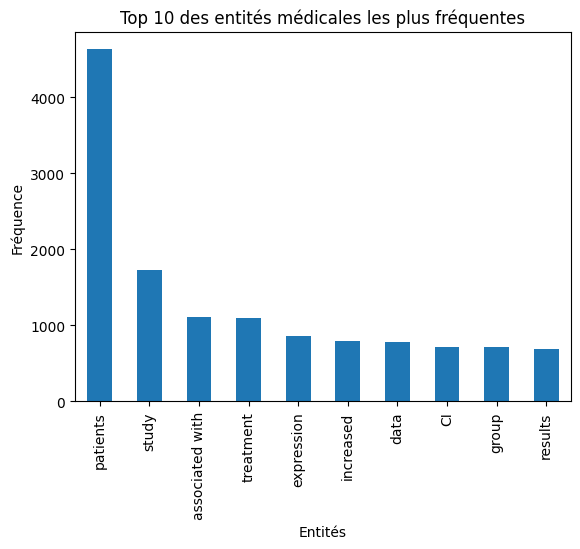

In [40]:
import matplotlib.pyplot as plt

# Visualiser les entités les plus fréquentes
entity_freq.plot(kind='bar')
plt.title('Top 10 des entités médicales les plus fréquentes')
plt.xlabel('Entités')
plt.ylabel('Fréquence')
plt.show()
